# Introduction

> Notebook setup

### Notebook functions and setup
The following are functions that are used within the notebook to reduce and DRY.

In [1]:
%load_ext autoreload
%autoreload 2


#eventually mode all but essential local to function blocks.
#import datetime
import logging
#import math
import os
import sys
#from datetime import datetime, timedelta

#import matplotlib.dates as mdates
#import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import seaborn as sns
#import ta
#from sklearn import svm
#from sklearn.metrics import (explained_variance_score, mean_squared_error,
#                             r2_score)

#from sklearn.model_selection import GridSearchCV
#from sklearn.svm import SVR
#from ta import add_all_ta_features

from src.features.build_features import StockTechnicals
from src.models.backtest_strategy import TradeHoldStrategy
from src.visualization.visualize import DisplayTicker

nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)


logging.basicConfig(
    stream=sys.stdout, 
    level=logging.INFO) #DEBUG to see all.

logger = logging.getLogger('NOTEBOOK_LOGGER')


# functions...

## pulling data.
def pull_data_files(data_path, symbols, start, end):
    import os
    import requests
    os.makedirs(data_path, exist_ok=True)
    parms = { 'period1': start, 'period2':end, 'interval': '1d', 'events': 'history' }
    base_url = 'https://query1.finance.yahoo.com/v7/finance/download/{}'
    for s in symbols:
        r = requests.get(base_url.format(s), params=parms)
        logger.debug('calling: {}'.format(r.url))

        filename = '{}/{}.csv'.format(data_path, s).replace('^', '_')

        with open(filename, 'wb') as fd:
            for chunk in r.iter_content(chunk_size=128):
                fd.write(chunk)


    logger.info('files downloaded to {}'.format(data_path))


def get_epoch_date(y,m,d):
    import datetime
    import math
    return math.trunc(datetime.datetime(y,m,d).timestamp())

def get_color_palette():
    #flatui from seaborn site
    return ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]

def convert_data_add_features(stock_ticker_csv, start_date, end_date, close_feature='Close'):
    """
    stock_ticker_csv : csv file
    end_date : string
    days_to_backtrack : int
    Takes in a CSV File and converts the date to numbers
    Returns DF with Dates converted to numerical format and the original Dates for plotting
    Adds some features to the DataFrame
    """
    from datetime import datetime, timedelta
    import matplotlib.dates as mdates
    import ta
    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    end_date = datetime.strptime(end_date, '%Y-%m-%d')
 

    # Load the CSV File
    stock_ticker = pd.read_csv(stock_ticker_csv, index_col=['Date'], parse_dates=['Date'])
    stock_ticker.sort_values('Date')
    stock_ticker = stock_ticker[start_date: end_date]
    #print(stock_ticker.info())

    stock_ticker.reset_index(inplace=True)
    
    data_df = stock_ticker.copy()
    data_df = data_df.reset_index()
    org_dates = data_df['Date']
    data_df['Pretty Date'] = data_df['Date']
    

    # Converting Dates to Numbers - SVR doesn't work with dates
    data_df['Date'] = data_df['Date'].map(mdates.date2num)

    indicator_bb = ta.volatility.BollingerBands(close=data_df[close_feature], n=20, ndev=2)
    indicator_SMA20 = ta.trend.SMAIndicator(close=data_df[close_feature],n=20, fillna=True)
    indicator_MACD = ta.trend.MACD(close=data_df[close_feature],n_fast=5, n_slow=30, fillna=True)
  
    # Features added to original date
    data_df['SMA_20'] = indicator_SMA20.sma_indicator()
    data_df['bb_bbm'] = indicator_bb.bollinger_mavg()
    data_df['bb_bbh'] = indicator_bb.bollinger_hband()
    data_df['bb_bbl'] = indicator_bb.bollinger_lband()
    data_df['MACD'] = indicator_MACD.macd()
    data_df['MACD signal'] = indicator_MACD.macd_signal()

    # Return DF with Dates converted to numerical format and the original Dates for plotting
    return data_df, org_dates


# support vector grid search parms
def svc_param_selection(X, y, nfolds, model):
    from sklearn.model_selection import GridSearchCV
    from sklearn import svm
    from sklearn.svm import SVR
    Cs = [10, 100, 1000, 10000, 100000]
    gammas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVR(kernel=model), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_

    return grid_search.best_params_


def predict_multiple_variables(ticker_df, dates_org, num_forecast_days, C_user=None, G_user=None, model =  'rbf', close_feature='Close'):
    from sklearn.svm import SVR
    from sklearn.metrics import (explained_variance_score, mean_squared_error,
                             r2_score)
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    features=['Date','SMA_20','Open','Volume', 'bb_bbl', 'MACD']
    num_training_days = len(ticker_df)
    days_to_predict = dates_org[-num_forecast_days:].dt.date
    print("=" * 100)
    print("Predicting values for the following dates: ")
    for d in days_to_predict:
        print(f'{d}')
    print("=" * 100)
    #print(f'{type(dates_org[-num_forecast_days:])}')
    #print(f'{type(dates_org[-num_forecast_days:].values)}')
    
    #print(dates_org[-num_forecast_days:])
    train_x = ticker_df[-(num_training_days+num_forecast_days):-num_forecast_days][features]
    # Seperate Predicted variable
    train_y = ticker_df[-(num_training_days+num_forecast_days):-num_forecast_days][[close_feature]]

     # Split off test days for forecasting
    test_x = ticker_df[-num_forecast_days:][features]
    test_y = ticker_df[-num_forecast_days:][[close_feature]]
    
    best_params = svc_param_selection(train_x, train_y.values.reshape(-1,), 3, model=model)

    if C_user is None or G_user is None:
        C_user = best_params["C"]
        G_user = best_params["gamma"]
        print(f'Using Grid Search Values C {C_user} and gamma {G_user} values')
    else:
        print(f'Using user provided C {C_user} and gamma {G_user} values')

    # Fit training data using SVR/RBF
    svr_rbf = SVR(kernel= model, C=C_user, gamma= G_user)
    
    svr_rbf.fit(train_x, train_y.values.reshape(-1,))

    
    
    y_pred = svr_rbf.predict(test_x)
    print("=" * 100)
    print("Predicted Values: {}".format(y_pred))
    print("-" * 100)
    print(f"Actual Values: {np.squeeze(test_y.values)}")
    print("-" * 100)
    print(f"Model Score: {svr_rbf.score(train_x, train_y)}")
    print("-" * 100)
    print(f"Mean Squared Error (MSE): {mean_squared_error(test_y, y_pred)}")
    print("-" * 100)
    print(f"RMSE: {np.sqrt(mean_squared_error(test_y, y_pred))}")
    print("=" * 100)

    plt.figure(figsize = (12,6))
    plt.plot(ticker_df['Pretty Date'][-(num_training_days+num_forecast_days):-num_forecast_days], 
                        svr_rbf.predict(train_x), 
                        color= 'red', label= 'Train Data')

    plt.plot(ticker_df['Pretty Date'][-(num_training_days+num_forecast_days):-num_forecast_days], 
                        train_y , 
                        color= 'black', 
                        label= 'Actual Data')
    plt.legend()
    plt.show()

    plt.figure(figsize = (12,6))

    ax = plt.gca()
    formatter = mdates.DateFormatter("%Y-%m-%d")
    ax.xaxis.set_major_formatter(formatter)
    locator = mdates.DayLocator()
    ax.xaxis.set_major_locator(locator)
    
    #print("xmin: {}".format(num_forecast_days:num_forecast_days+1 ))
    # if the forecast is one day, it will not plot a line

    if num_forecast_days == 1:
        plt.xlim(xmin=ticker_df['Pretty Date'][-num_forecast_days:], xmax=ticker_df['Pretty Date'][-1:])
        plt.scatter(ticker_df['Pretty Date'][-num_forecast_days:], svr_rbf.predict(test_x), 
                        color= 'green', 
                        label= 'Predicted Data')
        plt.scatter(ticker_df['Pretty Date'][-num_forecast_days:], test_y, 
                        color= 'black', 
                        label= 'Actual')

    # Otherwise, plot a line for x > 1
    
    else:
        plt.xlim(xmin=ticker_df['Pretty Date'][-num_forecast_days:-num_forecast_days+1], xmax=ticker_df['Pretty Date'][-1:])
        plt.plot(ticker_df['Pretty Date'][-num_forecast_days:], svr_rbf.predict(test_x), 
                        color= 'green', 
                        label= 'Predicted Data')
        plt.plot(ticker_df['Pretty Date'][-num_forecast_days:], test_y, 
                        color= 'black', 
                        label= 'Actual')
    
    #print("X max: {}, X Min: {}".format(xmax, xmin))
    plt.legend()
    plt.show()
    
    
def corr_plot(df):
    import seaborn as sns
    import matplotlib.pyplot as plt
    corrMatrix = df.drop(columns=['index','Date','Pretty Date']).corr()
    #print(corrMatrix.shape)
    import seaborn as sn
    plt.figure(figsize = (18,18))
    sn.heatmap(corrMatrix, 
            annot=True, 
            vmin = -1, 
            vmax=1, 
            center=0,
            fmt='.2g',
            linewidths=10,
            annot_kws={"size": 8},
            cbar_kws={"shrink": 1.0},
            cmap=get_color_palette(), #  sns.diverging_palette(20, 220, n=200),
            square=True)
   
    plt.show()

## Download the data from the Market Data Provider

> Note: this uses a local data path setting

In [2]:


## setup for file download to local path -- this is used for other
local_data_path = './.data'

## dates in epoch time
start_epoch = get_epoch_date(2008,3,30)
end_epoch   = get_epoch_date(2020,3,1)

# our symbols as needed by the provider. NOTE ^GSPC becomes _GSPC
symbols = ['MSFT', 'AAPL', 'GOOG', '^GSPC', 'AMZN' ]

# the actual pull
pull_data_files(local_data_path, symbols, start_epoch, end_epoch)

INFO:NOTEBOOK_LOGGER:files downloaded to ./.data


## Feature enrichment

This step changes dates to serial numbers and adds several features

- SMA 20
- bollinger band for 20 days:
    - Moving Average
    - High and Low band
- MACD


In [9]:

## setup some data frames for modeling
start_date = '2019-01-31'
end_date = '2020-03-31'

#file_target = '{}/{}.csv'

#MSFT, MSFT_dates = convert_data_add_features(file_target.format(local_data_path, 'MSFT'),start_date, end_date)
#AAPL, AAPL_dates = convert_data_add_features(file_target.format(local_data_path, 'AAPL'),start_date, end_date)
#AMZN, AMZN_dates = convert_data_add_features(file_target.format(local_data_path, 'AMZN'),start_date, end_date)
#GOOG, GOOG_dates = convert_data_add_features(file_target.format(local_data_path, 'GOOG'),start_date, end_date)
#_GSPC, _GSPC_dates = convert_data_add_features(file_target.format(local_data_path, '_GSPC'),start_date, end_date)


start_date = '2019-10-31'
end_date = '2019-12-31'
MSFT, MSFT_dates = convert_data_add_features('./.data/MSFT.csv',start_date, end_date)
AAPL, AAPL_dates = convert_data_add_features('./.data/AAPL.csv',start_date, end_date)
AMZN, AMZN_dates = convert_data_add_features('./.data/AMZN.csv',start_date, end_date)
GOOG, GOOG_dates = convert_data_add_features('./.data/GOOG.csv',start_date, end_date)
_GSPC, _GSPC_dates = convert_data_add_features('./.data/_GSPC.csv',start_date, end_date)

# Basic Exploratory Analysis

>TODO: what kind of diagrams, tables, etc. to put here?

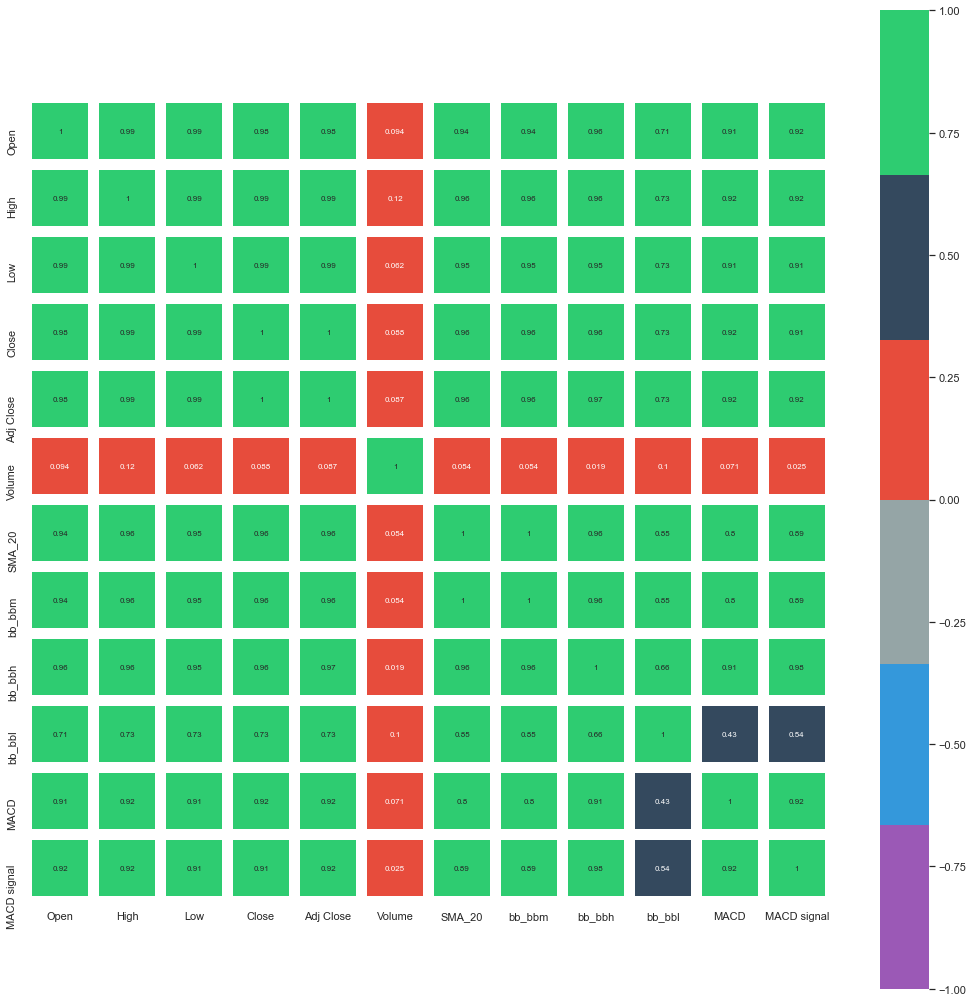

In [10]:
corr_plot(MSFT)

# Feature Wrangling and Setup

##  Predictions

### MSFT Predictions

Predicting values for the following dates: 
2019-12-24
2019-12-26
2019-12-27
2019-12-30
2019-12-31
Using user provided C 100 and gamma 0.009 values
Predicted Values: [150.07702751 150.07702751 150.07702751 150.07702751 150.07702751]
----------------------------------------------------------------------------------------------------
Actual Values: [157.380005 158.669998 158.960007 157.589996 157.699997]
----------------------------------------------------------------------------------------------------
Model Score: 0.9993038795850729
----------------------------------------------------------------------------------------------------
Mean Squared Error (MSE): 64.12686115558738
----------------------------------------------------------------------------------------------------
RMSE: 8.007924896974707


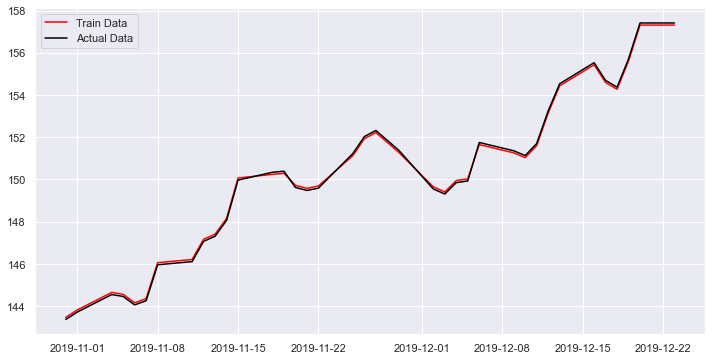

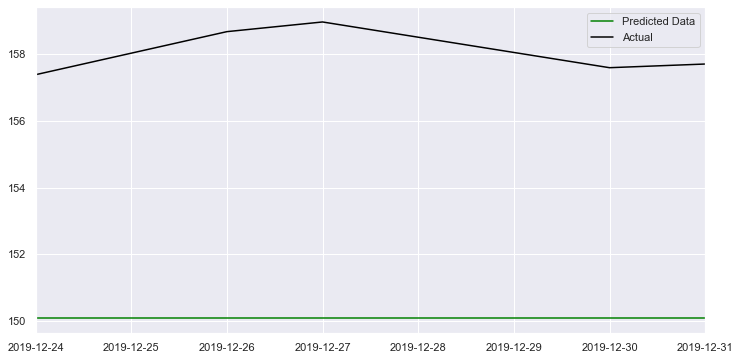

In [11]:
predict_multiple_variables(MSFT,MSFT_dates,num_forecast_days=5, C_user= 100, G_user=.009, model = 'rbf')

### AAPL Precitions

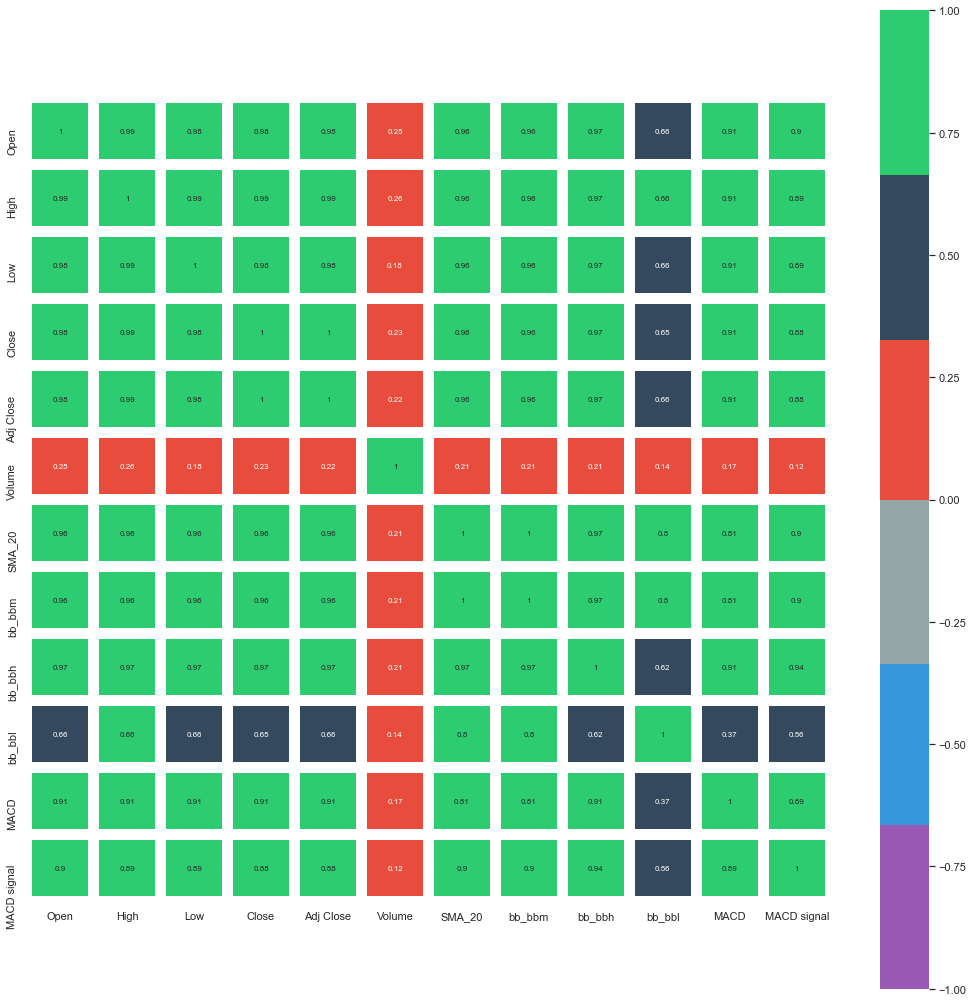

In [12]:
corr_plot(AAPL)

Predicting values for the following dates: 
2019-12-24
2019-12-26
2019-12-27
2019-12-30
2019-12-31
Using Grid Search Values C 10 and gamma 1e-05 values
Predicted Values: [265.85413921 265.85413921 265.85413921 265.85413921 265.85413921]
----------------------------------------------------------------------------------------------------
Actual Values: [284.269989 289.910004 289.799988 291.519989 293.649994]
----------------------------------------------------------------------------------------------------
Model Score: 0.9140000977308315
----------------------------------------------------------------------------------------------------
Mean Squared Error (MSE): 584.5154436499648
----------------------------------------------------------------------------------------------------
RMSE: 24.176754200056816


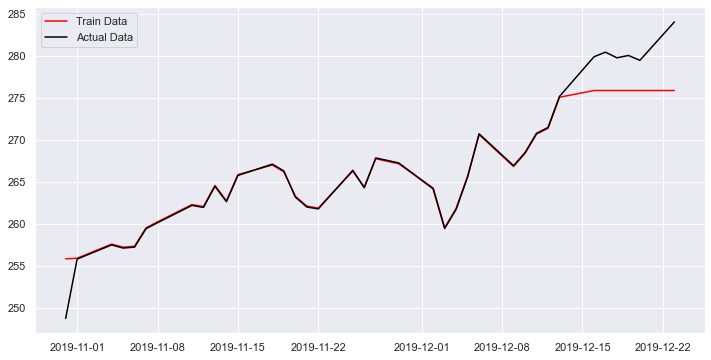

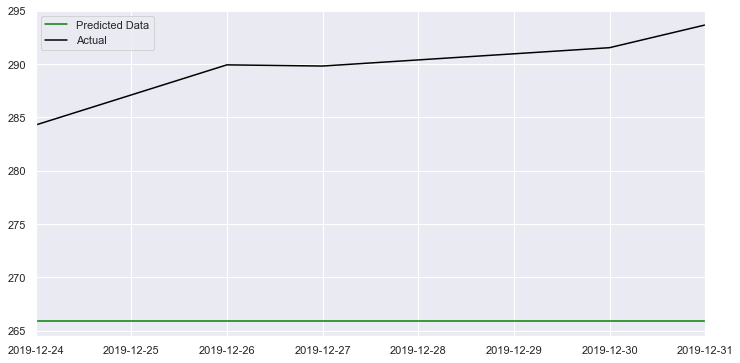

In [13]:
predict_multiple_variables(AAPL,AAPL_dates,num_forecast_days=5, model='rbf')

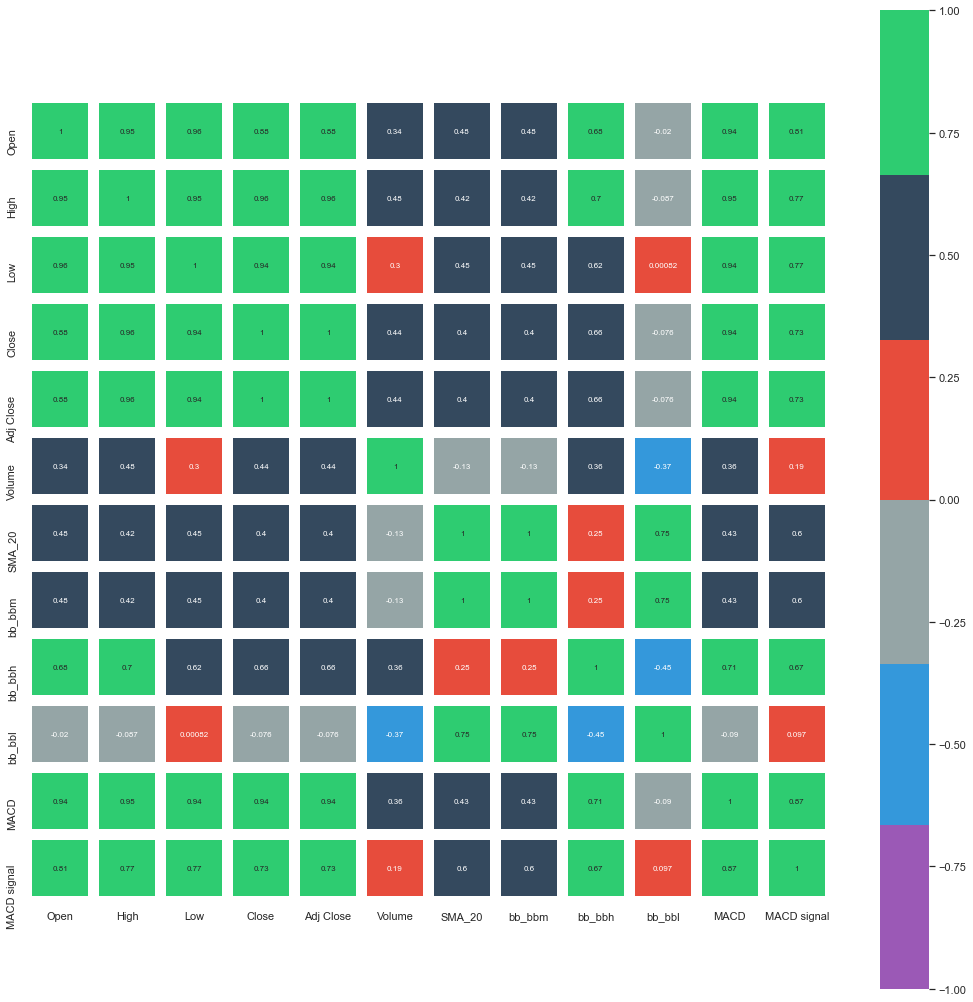

In [14]:
corr_plot(AMZN)

Predicting values for the following dates: 
2019-12-24
2019-12-26
2019-12-27
2019-12-30
2019-12-31
Using user provided C 100 and gamma 0.009 values
Predicted Values: [1771.38269303 1771.38269303 1771.38269303 1771.38269303 1771.38269303]
----------------------------------------------------------------------------------------------------
Actual Values: [1789.209961 1868.77002  1869.800049 1846.890015 1847.839966]
----------------------------------------------------------------------------------------------------
Model Score: 0.9999792426336678
----------------------------------------------------------------------------------------------------
Mean Squared Error (MSE): 6207.029831404974
----------------------------------------------------------------------------------------------------
RMSE: 78.78470556780024


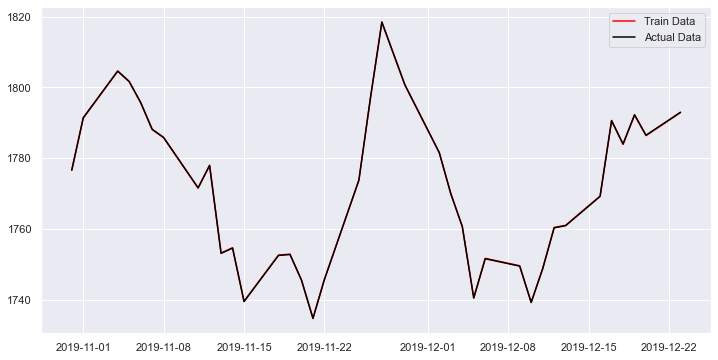

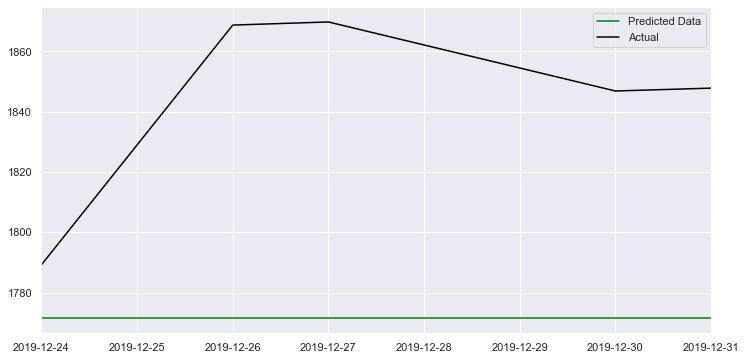

In [15]:
predict_multiple_variables(AMZN,AMZN_dates,num_forecast_days=5, C_user=100, G_user=.009)

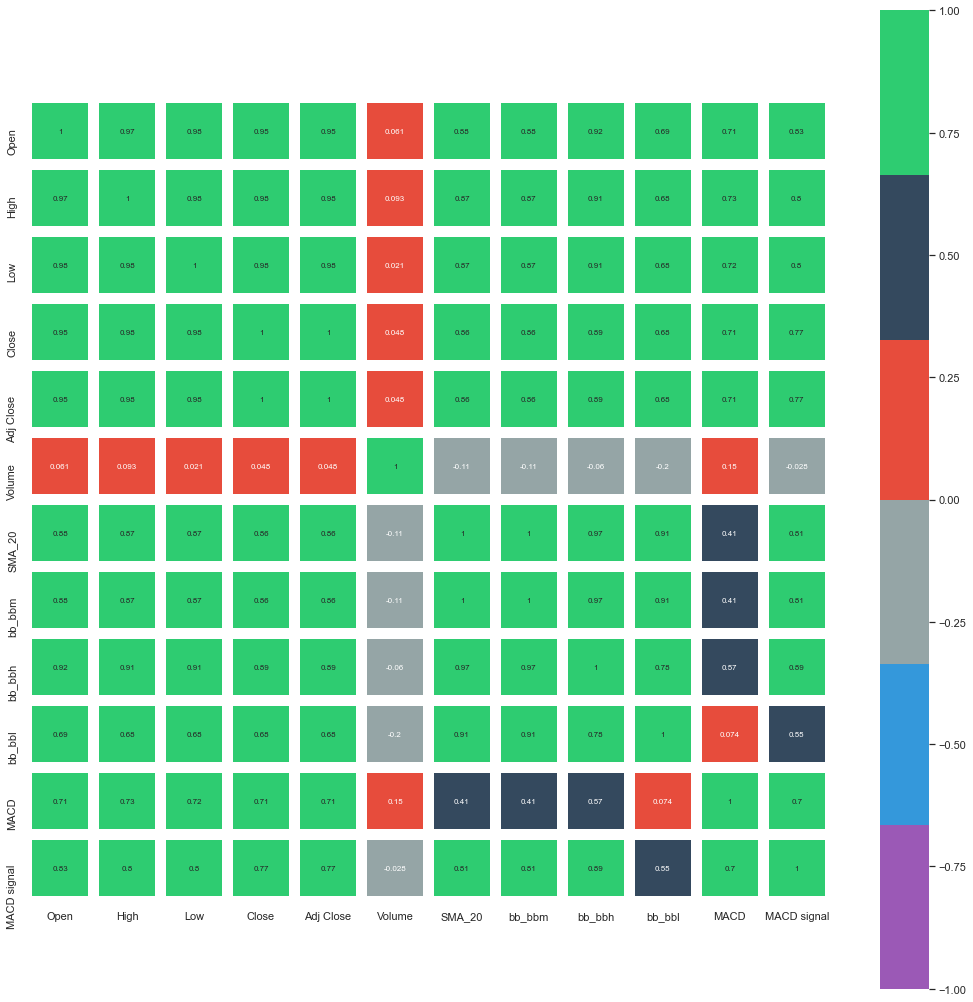

In [16]:

corr_plot(GOOG)

Predicting values for the following dates: 
2019-12-24
2019-12-26
2019-12-27
2019-12-30
2019-12-31
Using user provided C 120 and gamma 0.001 values
Predicted Values: [1318.25407582 1318.25407582 1318.25407582 1318.25407582 1318.25407582]
----------------------------------------------------------------------------------------------------
Actual Values: [1343.560059 1360.400024 1351.890015 1336.140015 1337.02002 ]
----------------------------------------------------------------------------------------------------
Model Score: 0.9999846613179266
----------------------------------------------------------------------------------------------------
Mean Squared Error (MSE): 844.0235236104243
----------------------------------------------------------------------------------------------------
RMSE: 29.0520829478787


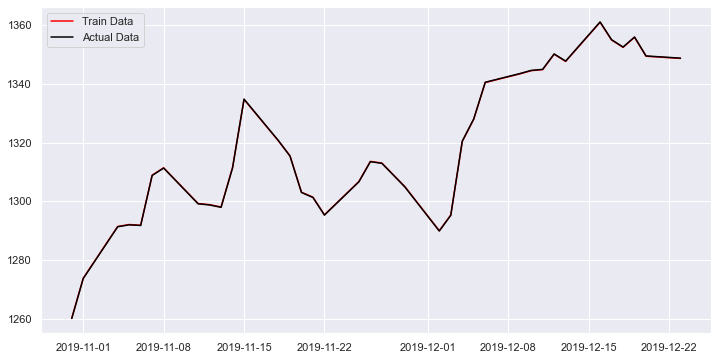

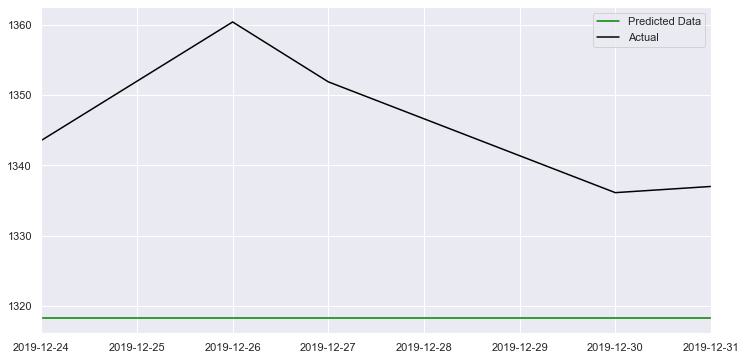

In [17]:
predict_multiple_variables(GOOG, GOOG_dates, num_forecast_days=5, C_user=120, G_user=.001,model =  'rbf')

# Model Creation and Tuning

# Results and Comparison

# Summary